In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint, uniform
from functools import reduce

In [2]:
df = pd.read_csv('../Dataset/ObesityDataset.csv')

In [3]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [5]:
x = df.drop('NObeyesdad', axis=1).copy()
x.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


In [6]:
y = df['NObeyesdad'].copy()
y.head()

0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: NObeyesdad, dtype: object

In [7]:
x_encoded = pd.get_dummies(x, columns=['Gender',
                                        'family_history_with_overweight',
                                        'FAVC',
                                        'CAEC',
                                        'SMOKE',
                                        'SCC',
                                        'CALC',
                                        'MTRANS'])  

x_encoded.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,True,False,...,False,False,False,False,True,False,False,False,True,False
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,True,False,...,True,False,False,True,False,False,False,False,True,False
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,False,True,...,False,False,True,False,False,False,False,False,True,False
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,False,True,...,False,False,True,False,False,False,False,False,False,True
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,False,True,...,False,False,False,True,False,False,False,False,True,False


In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded_series = pd.Series(y_encoded)

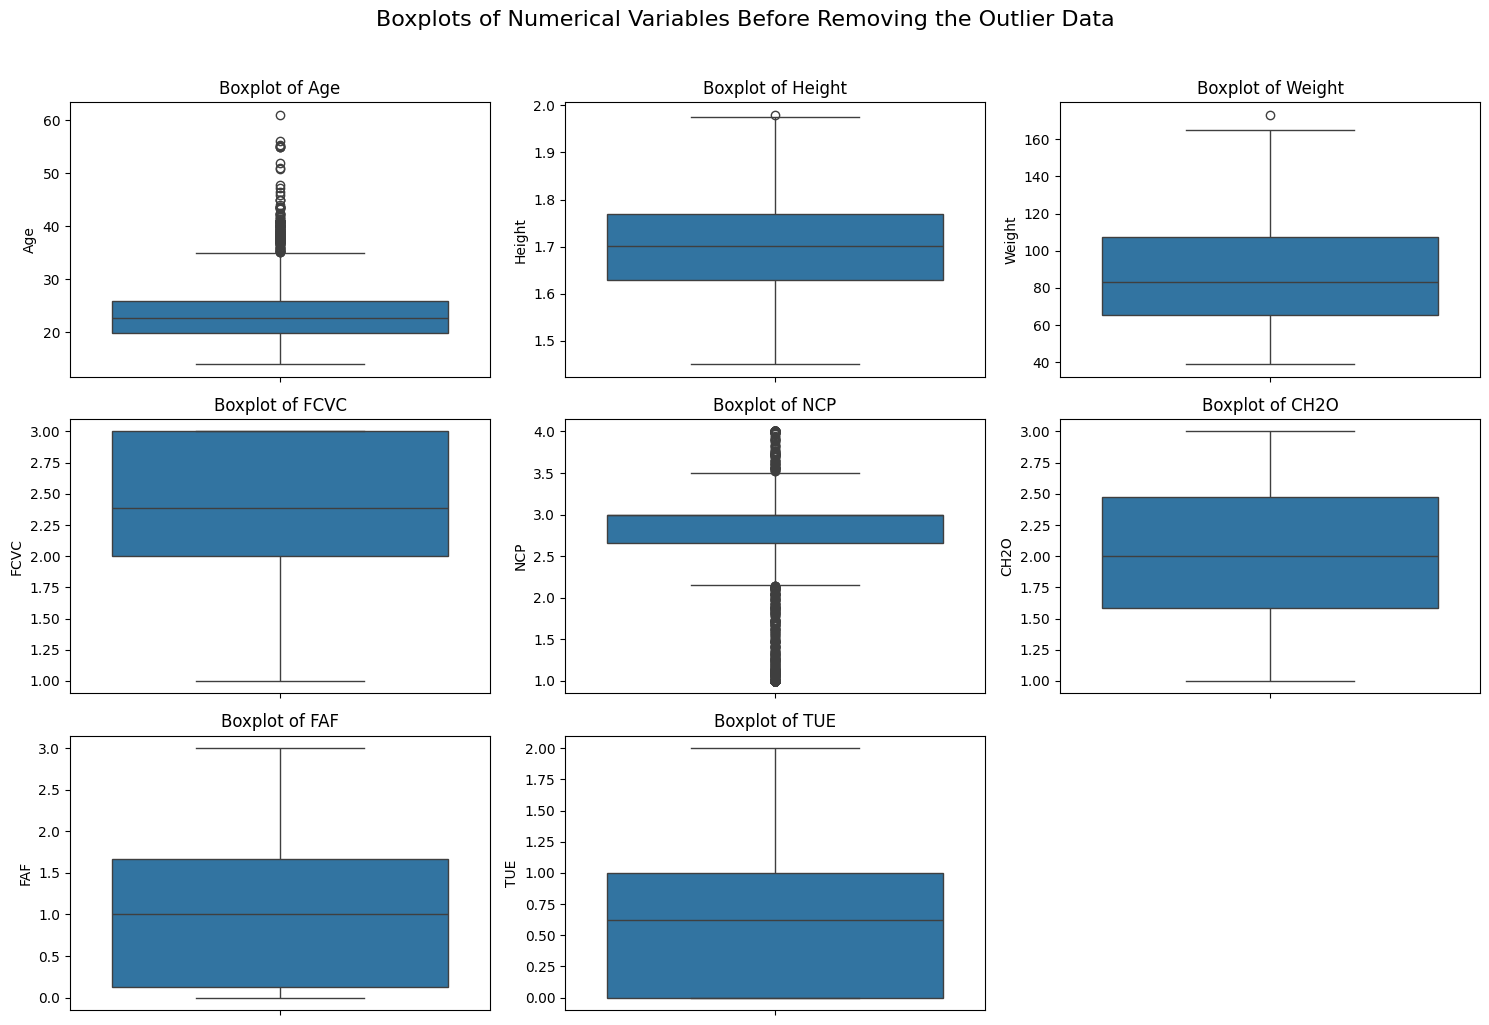

In [9]:
numerical_cols = x_encoded.select_dtypes(include='number').columns

plt.figure(figsize=(15, 10))
plt.suptitle('Boxplots of Numerical Variables Before Removing the Outlier Data', fontsize=16, y=1.02)
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=x_encoded[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [10]:
x_encoded_no_outliers = x_encoded.copy()
masks = []
for col in numerical_cols:
    Q1 = x_encoded[col].quantile(0.25)
    Q3 = x_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (x_encoded[col] >= lower_bound) & (x_encoded[col] <= upper_bound)
    masks.append(mask)

combined_mask = reduce(lambda a, b: a & b, masks)
x_encoded_no_outliers = x_encoded[combined_mask]

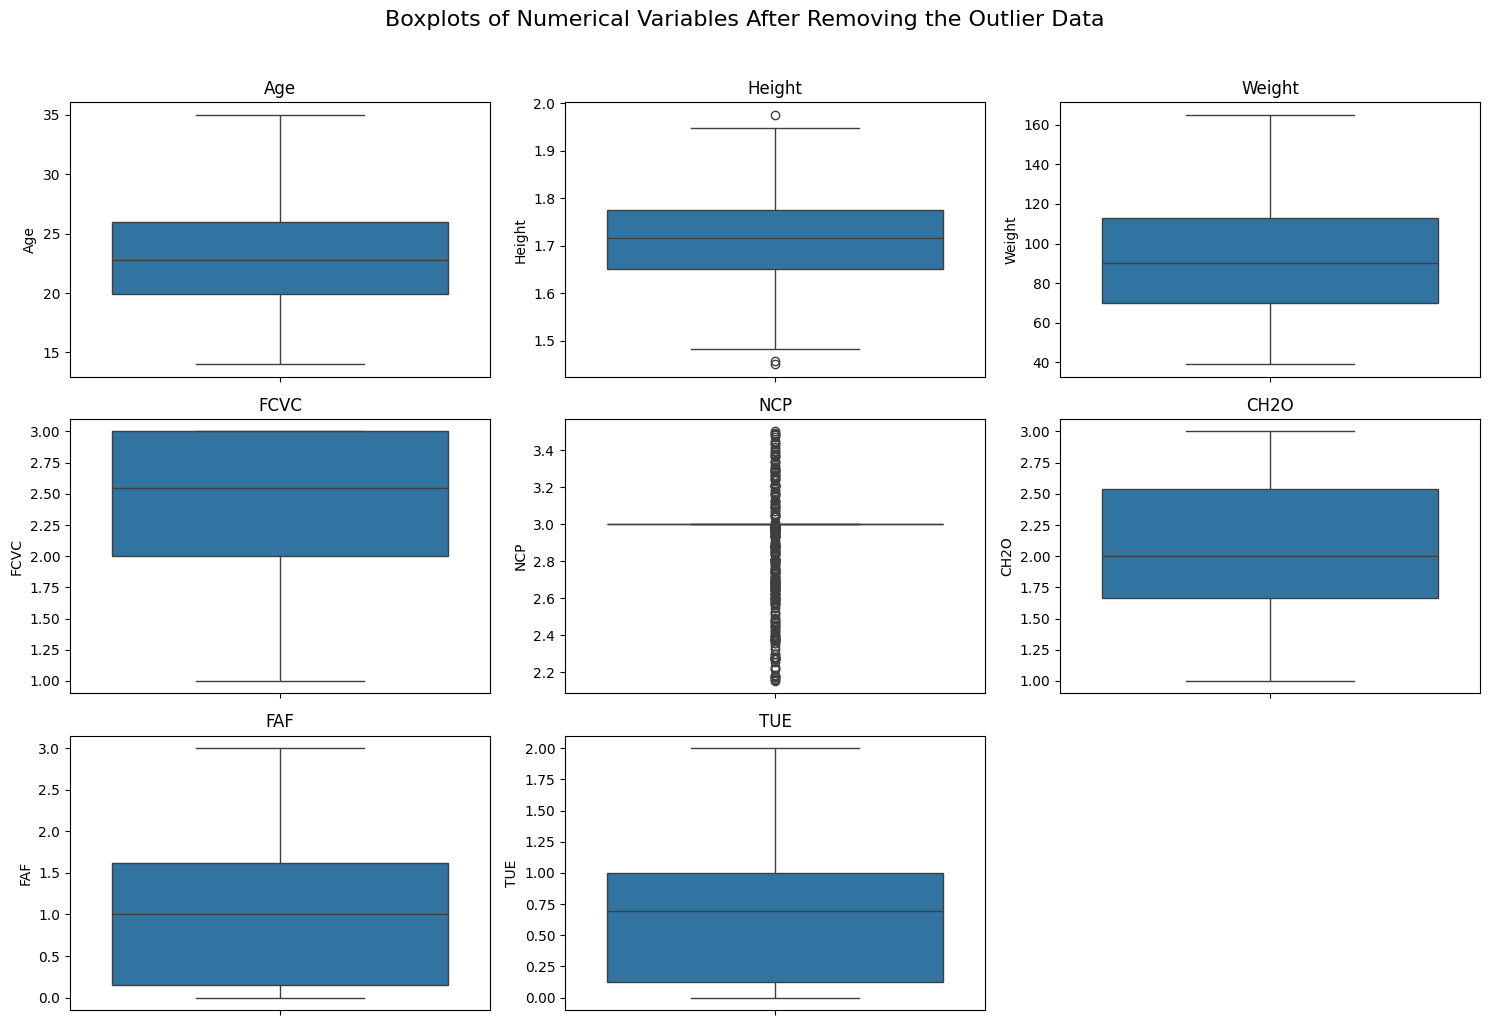

In [11]:
plt.figure(figsize=(15, 10))
plt.suptitle('Boxplots of Numerical Variables After Removing the Outlier Data', fontsize=16, y=1.02)
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=x_encoded_no_outliers[col])
    plt.title(f'{col}')
    plt.tight_layout()

plt.show()


In [12]:
scaled = StandardScaler()
x_scaled = scaled.fit_transform(x_encoded_no_outliers)

In [13]:
x_scaled_df = pd.DataFrame(x_scaled, columns=x_encoded_no_outliers.columns)

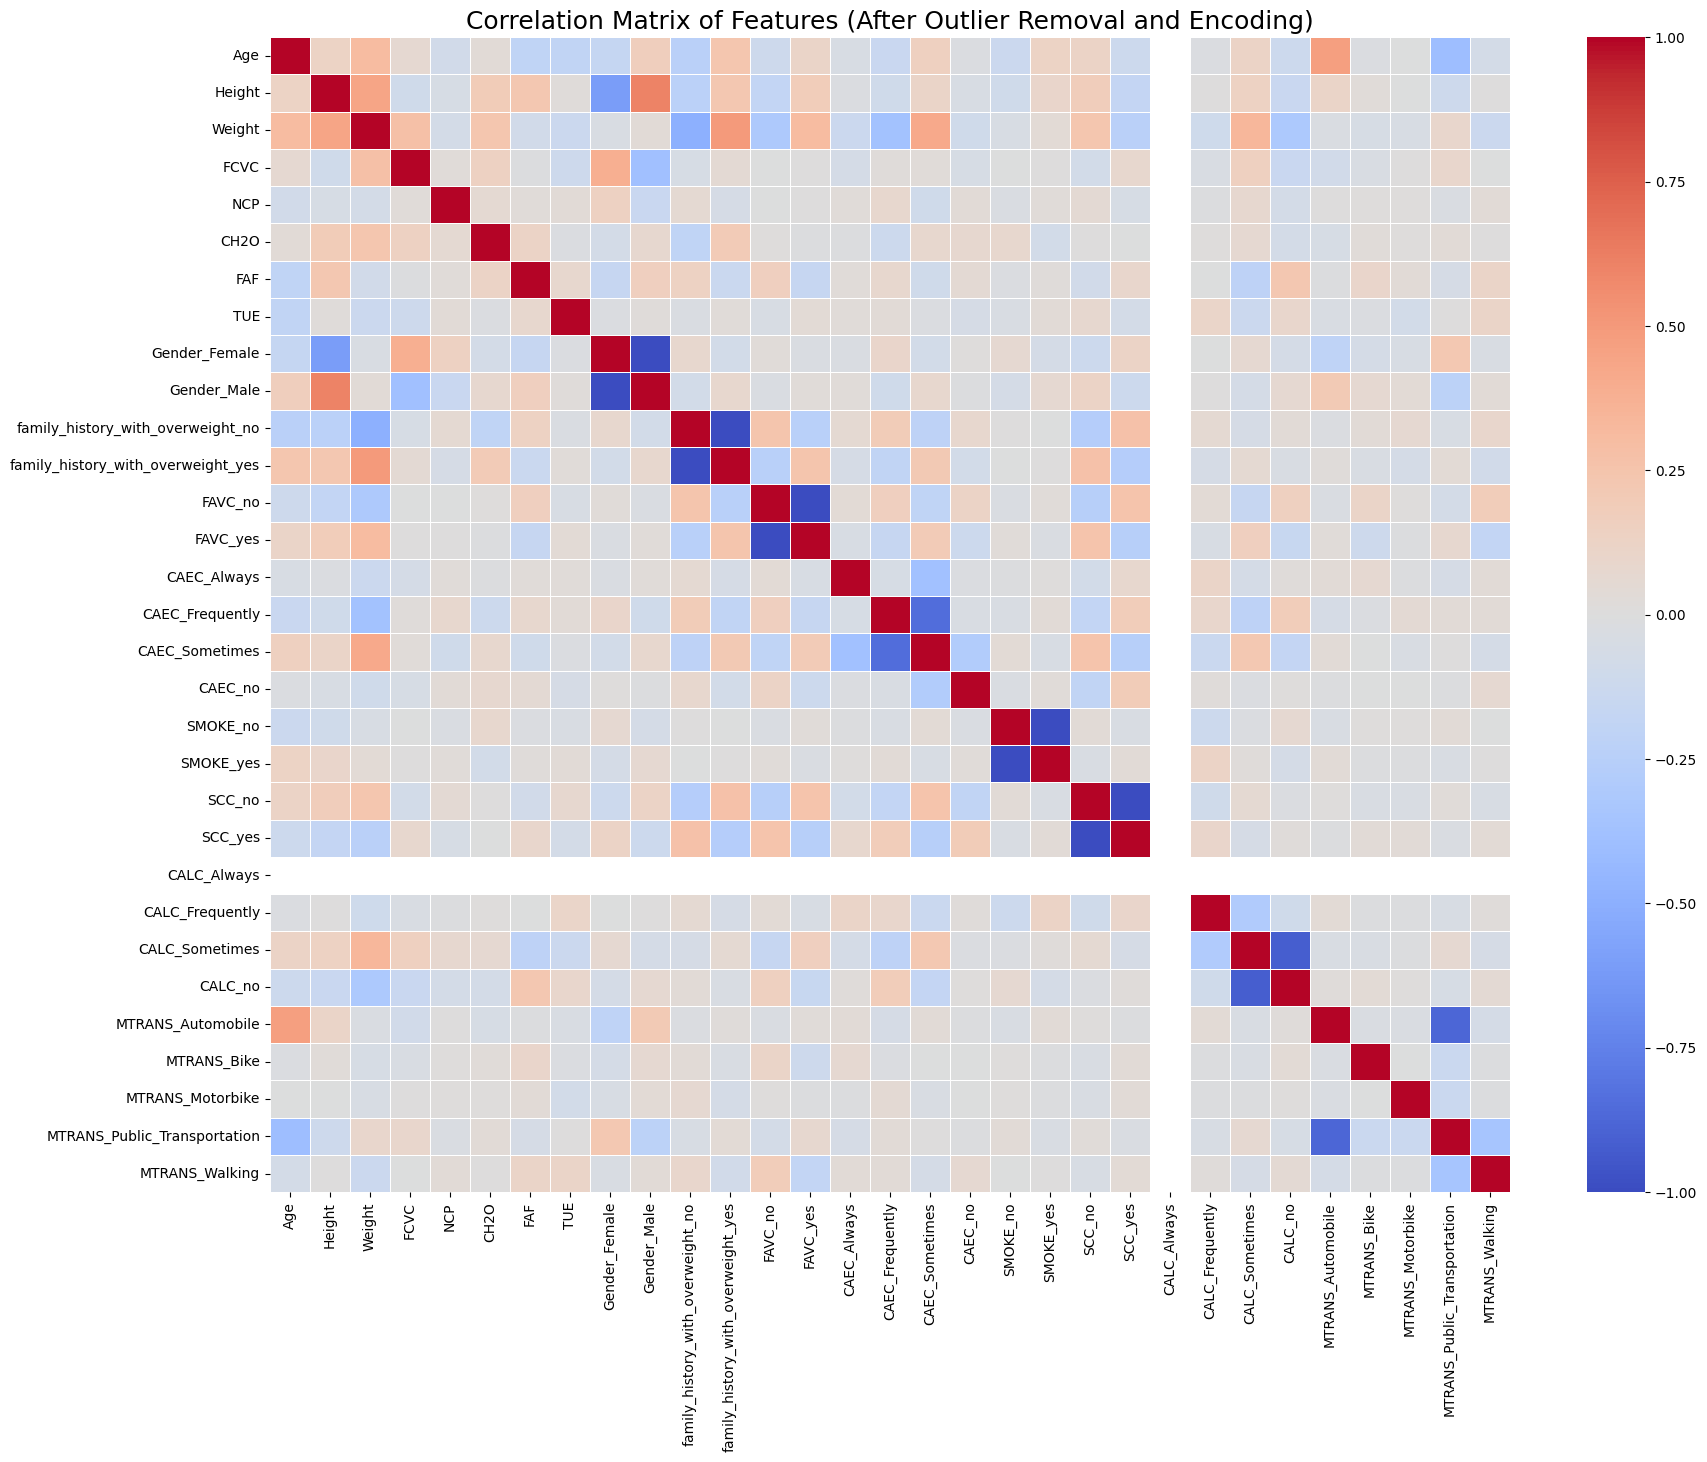

In [14]:
correlation_matrix = x_encoded_no_outliers.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features (After Outlier Removal and Encoding)', fontsize=18)
plt.show()

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y_encoded[combined_mask],
    test_size=0.2, stratify=y_encoded[combined_mask], random_state=42
)


XGBoost Training Model

In [16]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

XGBoost Training Model With Randomized Search

In [17]:
param_dist = {
    'n_estimators': randint(100, 201),
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 6),
    'colsample_bytree': uniform(0.6, 0.4),
    'subsample': uniform(0.6, 0.4),
    'learning_rate': uniform(0.01, 0.19), 
    'gamma': uniform(0, 0.2), 
}

clf_xgb_randomized = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    seed=42,
    eval_metric='mlogloss'
)

xgb_random_search = RandomizedSearchCV(
    estimator=clf_xgb_randomized,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=3, 
    verbose=1,
    n_jobs=-1,
    random_state=42
)

xgb_random_search.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C763708550>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C763708B90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C7611D7380>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C7637087D0>},
                   random_state=42, scoring='accuracy', verbose=1)

XGBoost Training Model With Grid Search

In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3],
    'colsample_bytree': [0.8],
    'subsample': [0.8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1],
}

clf_xgb_grid = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    seed=42,
    eval_metric='mlogloss'
)

xgb_grid_search = GridSearchCV(
    estimator=clf_xgb_grid,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=7, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3],
                         'n_estimators': [50, 100, 200], 'subsample': [0.8]},
             scoring='accuracy', verbose=1)

Random Forest Training Model

In [19]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

Random Forest Training Model With Randomized Search

In [20]:
param_dist_rf = {
    'n_estimators': randint(100, 501),
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': randint(2, 6),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'min_samples_leaf': randint(1, 4),
}

rf_random_search = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_random_search,
    param_distributions=param_dist_rf,
    n_iter=100,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

random_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 15, 20, 25, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C763750DD0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C7637450F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C763745220>},
                   random_state=42, scoring='accuracy', verbose=1)

Random Forest Training Model With Grid Search

In [21]:
param_grid_rf = {
    'n_estimators': [250, 300, 350],
    'max_depth': [12, 15, 18],
    'min_samples_split': [2, 3],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'min_samples_leaf': [1, 2],
}

rf_grid_search = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_grid_search,
    param_grid=param_grid_rf,
    cv=5,
    verbose=1,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search_rf.fit(x_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [12, 15, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 300, 350]},
             scoring='accuracy', verbose=1)

K-Nearest Neighbors Training Model

In [22]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=7)

K-Nearest Neighbors Training Model With Randomized Search

In [23]:
param_dist_knn= {
    'n_neighbors': randint(1, 31), 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': randint(20, 61),
    'p': randint(1, 3),
}

knn_random_search = KNeighborsClassifier()

random_search_knn = RandomizedSearchCV(
    estimator=knn_random_search,
    param_distributions=param_dist_knn,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_knn.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C763AF9AE0>,
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C763AF8C00>,
                                        'p': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C7636B5850>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='accuracy', verbose=1)

K-Nearest Neighbors Training Model With Grid Search

In [24]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'minkowski', 'euclidean'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
} 

knn_grid_search = KNeighborsClassifier()

grid_search_knn = GridSearchCV(
    estimator=knn_grid_search,
    param_grid=param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(x_train, y_train)


Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 40],
                         'metric': ['manhattan', 'minkowski', 'euclidean'],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [25]:
search_results = [
    ('XGBoost Randomized Search', xgb_random_search.best_params_),
    ('XGBoost Grid Search', xgb_grid_search.best_params_),
    ('Random Forest Randomized Search', random_search_rf.best_params_),
    ('Random Forest Grid Search', grid_search_rf.best_params_),
    ('KNN Randomized Search', random_search_knn.best_params_),
    ('KNN Grid Search', grid_search_knn.best_params_)
]

for model_name, best_params in search_results:
    print(f"{model_name}: {best_params}")


XGBoost Randomized Search: {'colsample_bytree': np.float64(0.69489963499872), 'gamma': np.float64(0.06507993963185355), 'learning_rate': np.float64(0.1518333669724246), 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 132, 'subsample': np.float64(0.8170160922219597)}
XGBoost Grid Search: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Random Forest Randomized Search: {'bootstrap': True, 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 127}
Random Forest Grid Search: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
KNN Randomized Search: {'leaf_size': 27, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
KNN Grid Search: {'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


XGBoost Confusion Matrix

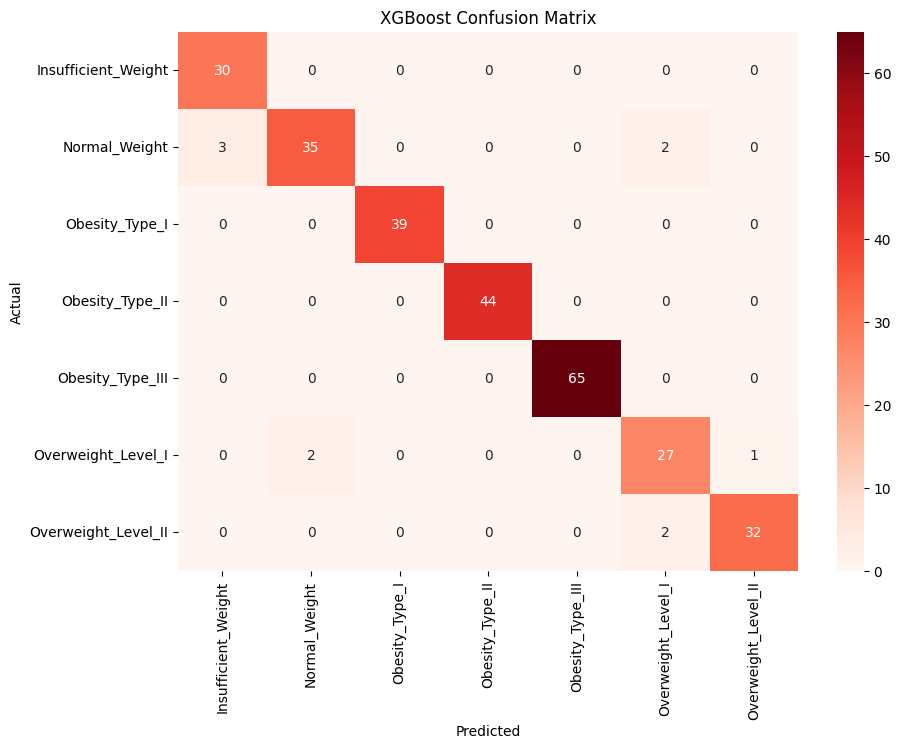

In [26]:
y_pred = clf_xgb.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

XGBoost Confusion Matrix (Randomized Search)

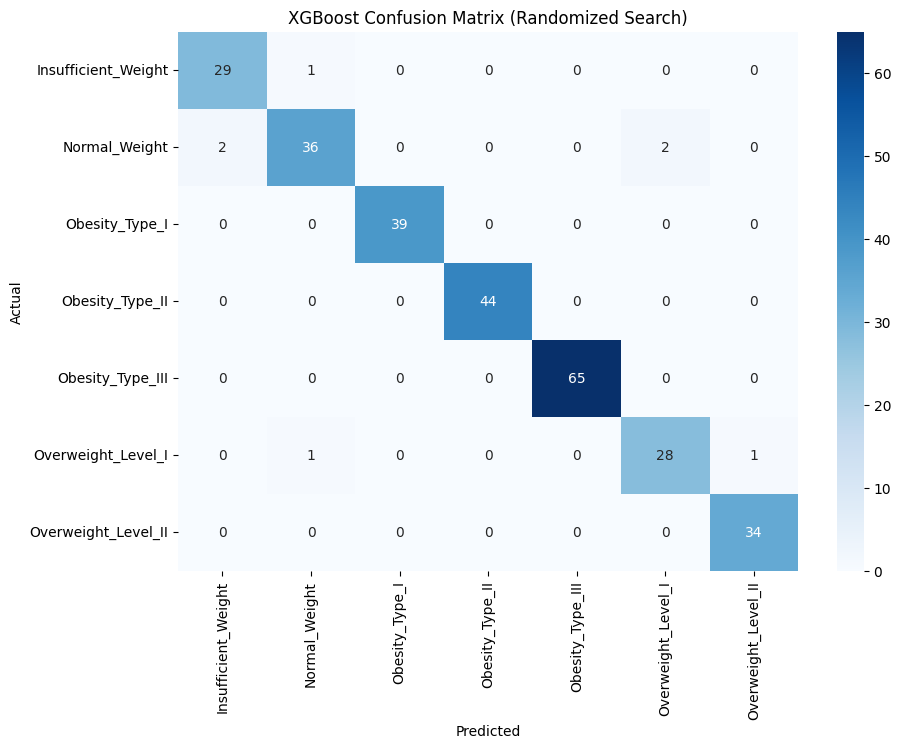

In [27]:
xgb_randomized_best_model = xgb_random_search.best_estimator_

y_pred_random = xgb_randomized_best_model.predict(x_test)

cm_random = confusion_matrix(y_test, y_pred_random)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_random, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix (Randomized Search)')
plt.show()

XGBoost Confusion Matrix (Grid Search)

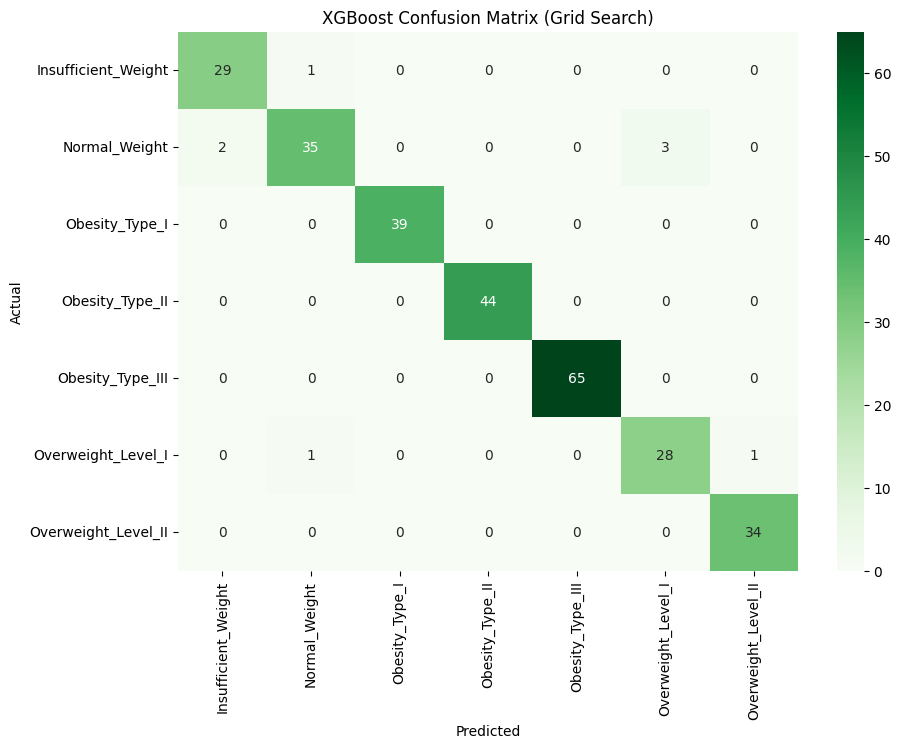

In [28]:
xgb_grid_best_model = xgb_grid_search.best_estimator_

y_pred_grid = xgb_grid_best_model.predict(x_test)

cm_grid = confusion_matrix(y_test, y_pred_grid)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_grid, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix (Grid Search)')
plt.show()

Random Forest Confusion Matrix

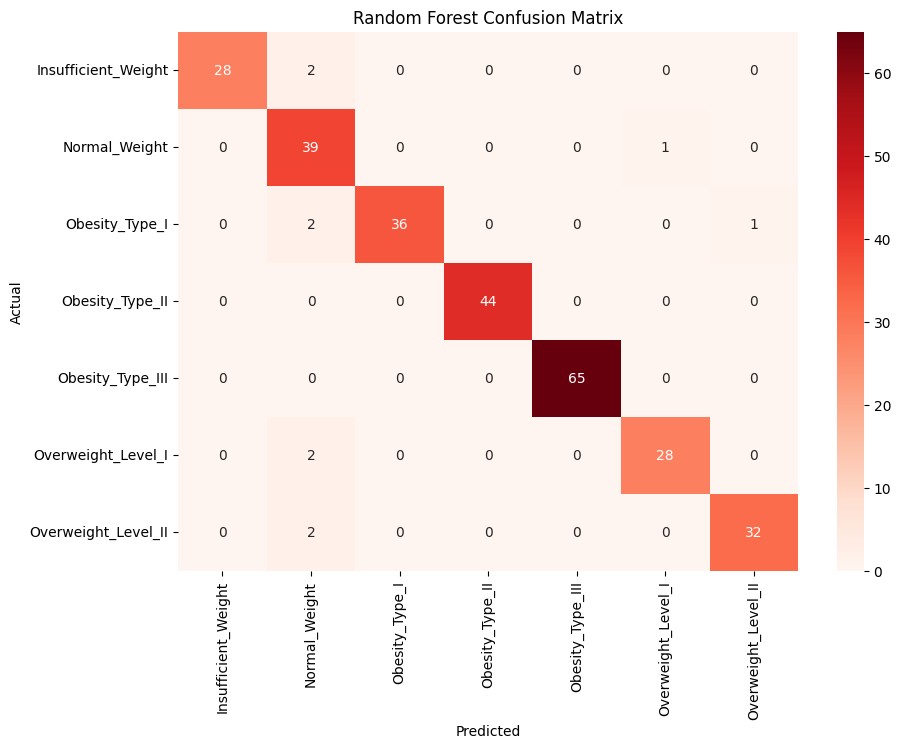

In [29]:
y_pred_rf = rf.predict(x_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Reds", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

Random Forest Confusion Matrix (Randomized Search)

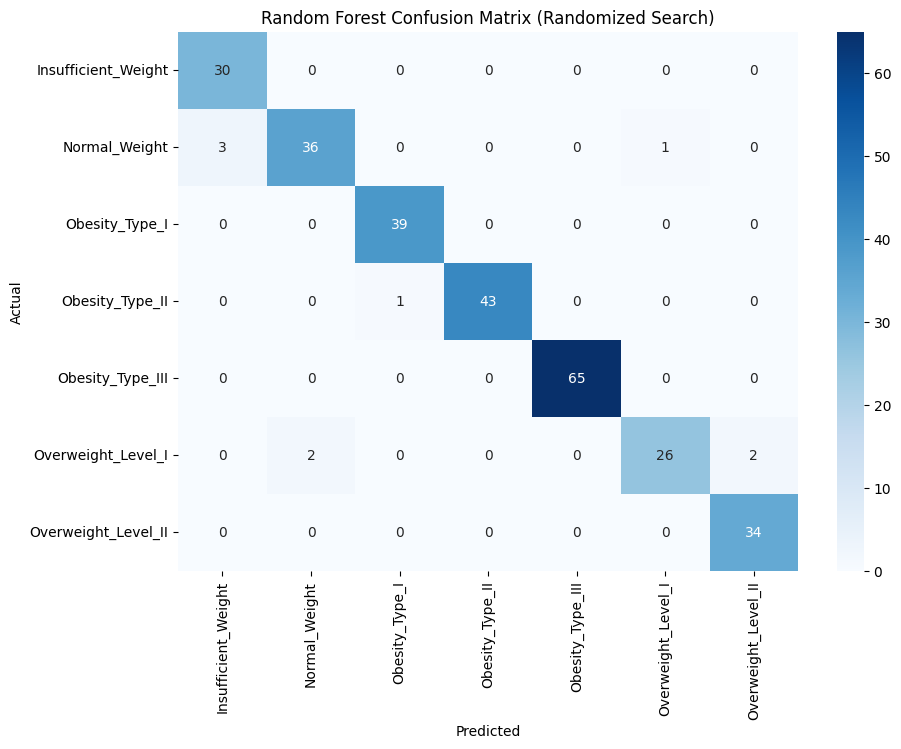

In [30]:
rf_randomized_best_model = random_search_rf.best_estimator_

y_pred_rf_random = rf_randomized_best_model.predict(x_test)
cm_rf_random = confusion_matrix(y_test, y_pred_rf_random)

plt.figure(figsize=(10,7))
sns.heatmap(cm_rf_random, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix (Randomized Search)')
plt.show()

Random Forest Confusion Matrix With Grid Search

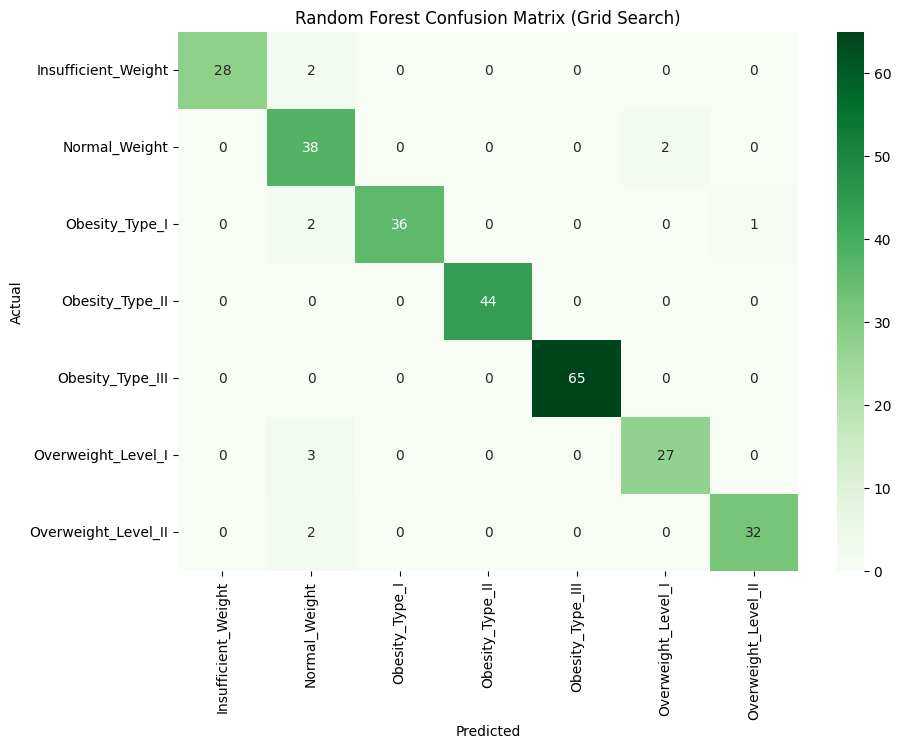

In [31]:
rf_grid_best_model = grid_search_rf.best_estimator_

y_pred_rf_grid = rf_grid_best_model.predict(x_test)
cm_rf_grid = confusion_matrix(y_test, y_pred_rf_grid)

plt.figure(figsize=(10,7))
sns.heatmap(cm_rf_grid, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix (Grid Search)')
plt.show()

K-Nearest Neighbors Confusion Matrix

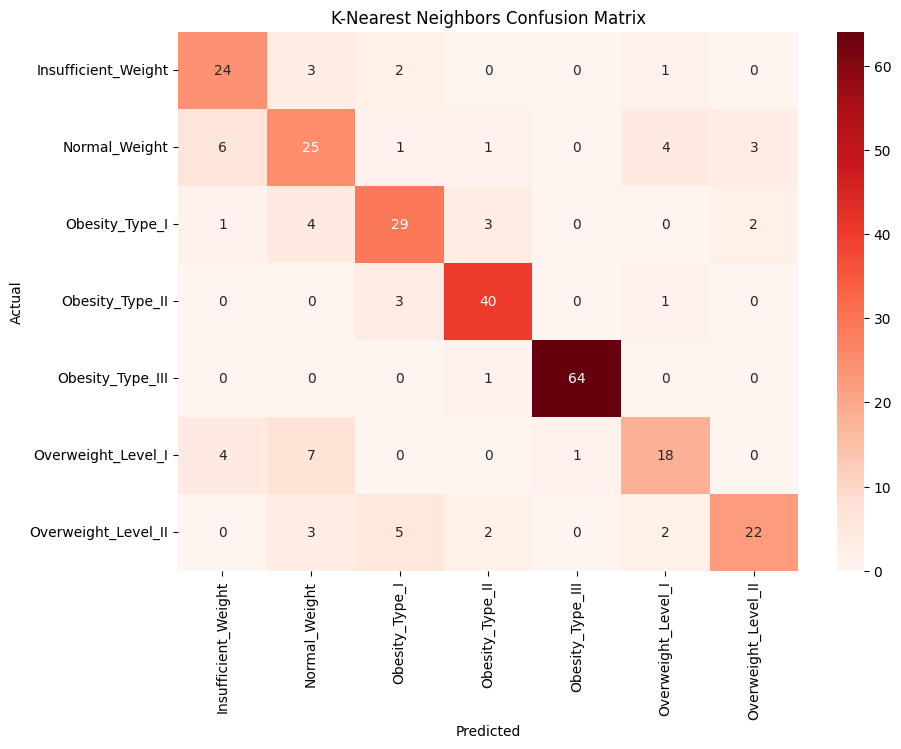

In [32]:
y_pred_knn = knn.predict(x_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10,7))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Reds", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()

K-Nearest Neighbors Confusion Matrix (Randomized Search)

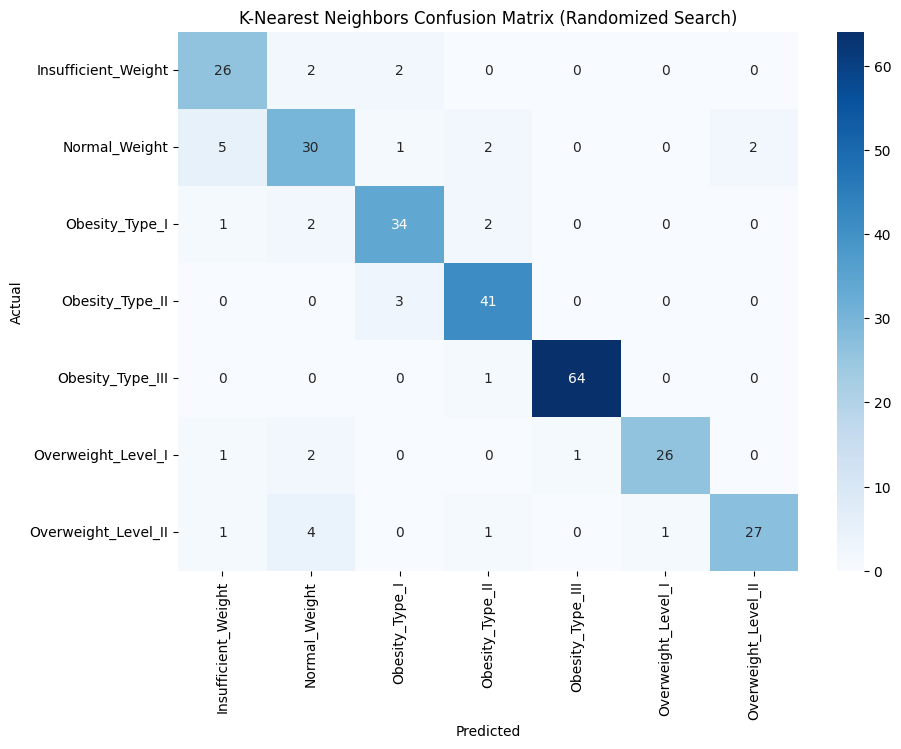

In [33]:
knn_randomized_best_model = random_search_knn.best_estimator_

y_pred_knn_random = knn_randomized_best_model.predict(x_test)
cm_knn_random = confusion_matrix(y_test, y_pred_knn_random)

plt.figure(figsize=(10,7))
sns.heatmap(cm_knn_random, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-Nearest Neighbors Confusion Matrix (Randomized Search)')
plt.show()

K-Nearest Neighbors Confusion Matrix (Grid Search)

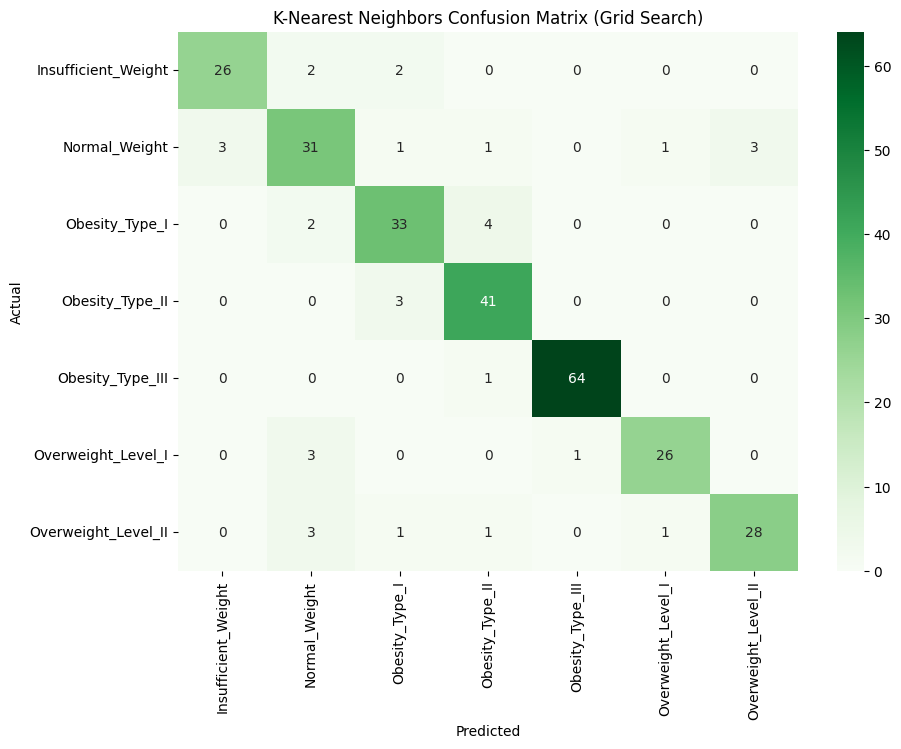

In [34]:
knn_grid_best_model = grid_search_knn.best_estimator_

y_pred_knn_grid = knn_grid_best_model.predict(x_test)
cm_knn_grid = confusion_matrix(y_test, y_pred_knn_grid)

plt.figure(figsize=(10,7))
sns.heatmap(cm_knn_grid, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('K-Nearest Neighbors Confusion Matrix (Grid Search)')
plt.show()

XGBoost Accuracy and Classification Report

In [35]:
xgb_report = classification_report(y_test, y_pred, target_names=le.classes_)
xgb_accuracy = accuracy_score(y_test, y_pred)

print(f"XGBoost Accuracy: {xgb_accuracy * 100:.2f}%")
print(xgb_report)

XGBoost Accuracy: 96.45%
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      1.00      0.95        30
      Normal_Weight       0.95      0.88      0.91        40
     Obesity_Type_I       1.00      1.00      1.00        39
    Obesity_Type_II       1.00      1.00      1.00        44
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.87      0.90      0.89        30
Overweight_Level_II       0.97      0.94      0.96        34

           accuracy                           0.96       282
          macro avg       0.96      0.96      0.96       282
       weighted avg       0.97      0.96      0.96       282



XGBoost Accuracy and Classification Report With Randomized Search

In [36]:
xgb_randomized_report = classification_report(y_test, y_pred_random, target_names=le.classes_)
xgb_randomized_accuracy = accuracy_score(y_test, y_pred_random)

print(f"XGBoost Accuracy (Randomized Search): {xgb_randomized_accuracy * 100:.2f}%")
print(xgb_randomized_report)

XGBoost Accuracy (Randomized Search): 97.52%
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.97      0.95        30
      Normal_Weight       0.95      0.90      0.92        40
     Obesity_Type_I       1.00      1.00      1.00        39
    Obesity_Type_II       1.00      1.00      1.00        44
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.93      0.93      0.93        30
Overweight_Level_II       0.97      1.00      0.99        34

           accuracy                           0.98       282
          macro avg       0.97      0.97      0.97       282
       weighted avg       0.98      0.98      0.98       282



XGBoost Accuracy and Classification Report with Grid Search

In [37]:
xgb_grid_report = classification_report(y_test, y_pred_grid, target_names=le.classes_)
xgb_grid_accuracy = accuracy_score(y_test, y_pred_grid)

print(f"XGBoost Accuracy (Grid Search): {xgb_grid_accuracy * 100:.2f}%")
print(xgb_grid_report)

XGBoost Accuracy (Grid Search): 97.16%
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.97      0.95        30
      Normal_Weight       0.95      0.88      0.91        40
     Obesity_Type_I       1.00      1.00      1.00        39
    Obesity_Type_II       1.00      1.00      1.00        44
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.90      0.93      0.92        30
Overweight_Level_II       0.97      1.00      0.99        34

           accuracy                           0.97       282
          macro avg       0.97      0.97      0.97       282
       weighted avg       0.97      0.97      0.97       282



Random Forest Accuracy and Classification Report

In [38]:
rf_report = classification_report(y_test, y_pred_rf, target_names=le.classes_)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(rf_report)

Random Forest Accuracy: 96.45%
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.93      0.97        30
      Normal_Weight       0.83      0.97      0.90        40
     Obesity_Type_I       1.00      0.92      0.96        39
    Obesity_Type_II       1.00      1.00      1.00        44
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.97      0.93      0.95        30
Overweight_Level_II       0.97      0.94      0.96        34

           accuracy                           0.96       282
          macro avg       0.97      0.96      0.96       282
       weighted avg       0.97      0.96      0.97       282



Random Forest Accuracy and Classification Report With Randomized Search

In [39]:
rf_randomized_report = classification_report(y_test, y_pred_rf_random, target_names=le.classes_)
rf_randomized_accuracy = accuracy_score(y_test, y_pred_rf_random)

print(f"Random Forest Accuracy (Randomized Search): {rf_randomized_accuracy * 100:.2f}%")
print(rf_randomized_report)

Random Forest Accuracy (Randomized Search): 96.81%
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      1.00      0.95        30
      Normal_Weight       0.95      0.90      0.92        40
     Obesity_Type_I       0.97      1.00      0.99        39
    Obesity_Type_II       1.00      0.98      0.99        44
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.96      0.87      0.91        30
Overweight_Level_II       0.94      1.00      0.97        34

           accuracy                           0.97       282
          macro avg       0.96      0.96      0.96       282
       weighted avg       0.97      0.97      0.97       282



Random Forest Accuracy and Classification Report With Grid Search

In [40]:
rf_grid_report = classification_report(y_test, y_pred_rf_grid, target_names=le.classes_)
rf_grid_accuracy = accuracy_score(y_test, y_pred_rf_grid)

print(f"Random Forest Accuracy (Grid Search): {rf_grid_accuracy * 100:.2f}%")
print(rf_grid_report)

Random Forest Accuracy (Grid Search): 95.74%
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.93      0.97        30
      Normal_Weight       0.81      0.95      0.87        40
     Obesity_Type_I       1.00      0.92      0.96        39
    Obesity_Type_II       1.00      1.00      1.00        44
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.93      0.90      0.92        30
Overweight_Level_II       0.97      0.94      0.96        34

           accuracy                           0.96       282
          macro avg       0.96      0.95      0.95       282
       weighted avg       0.96      0.96      0.96       282



K-Nearest Neighbors Accuracy and Classification

In [41]:
knn_report = classification_report(y_test, y_pred_knn, target_names=le.classes_)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"K-Nearest Neighbors Accuracy: {knn_accuracy * 100:.2f}%")
print(knn_report)

K-Nearest Neighbors Accuracy: 78.72%
                     precision    recall  f1-score   support

Insufficient_Weight       0.69      0.80      0.74        30
      Normal_Weight       0.60      0.62      0.61        40
     Obesity_Type_I       0.72      0.74      0.73        39
    Obesity_Type_II       0.85      0.91      0.88        44
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.69      0.60      0.64        30
Overweight_Level_II       0.81      0.65      0.72        34

           accuracy                           0.79       282
          macro avg       0.76      0.76      0.76       282
       weighted avg       0.79      0.79      0.79       282



K-Nearest Neighbors Accuracy and Classification With Randomized Search

In [42]:
knn_randomized_report = classification_report(y_test, y_pred_knn_random, target_names=le.classes_)
knn_randomized_accuracy = accuracy_score(y_test, y_pred_knn_random)

print(f"K-Nearest Neighbors Accuracy (Randomized Search): {knn_randomized_accuracy * 100:.2f}%")
print(knn_randomized_report)

K-Nearest Neighbors Accuracy (Randomized Search): 87.94%
                     precision    recall  f1-score   support

Insufficient_Weight       0.76      0.87      0.81        30
      Normal_Weight       0.75      0.75      0.75        40
     Obesity_Type_I       0.85      0.87      0.86        39
    Obesity_Type_II       0.87      0.93      0.90        44
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.96      0.87      0.91        30
Overweight_Level_II       0.93      0.79      0.86        34

           accuracy                           0.88       282
          macro avg       0.87      0.87      0.87       282
       weighted avg       0.88      0.88      0.88       282



K-Nearest Neighbors Accuracy and Classification With Grid Search

In [43]:
knn_grid_report = classification_report(y_test, y_pred_knn_grid, target_names=le.classes_)
knn_grid_accuracy = accuracy_score(y_test, y_pred_knn_grid)

print(f"K-Nearest Neighbors Accuracy (Grid Search): {knn_grid_accuracy * 100:.2f}%")
print(knn_grid_report)

K-Nearest Neighbors Accuracy (Grid Search): 88.30%
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.87      0.88        30
      Normal_Weight       0.76      0.78      0.77        40
     Obesity_Type_I       0.82      0.85      0.84        39
    Obesity_Type_II       0.85      0.93      0.89        44
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.93      0.87      0.90        30
Overweight_Level_II       0.90      0.82      0.86        34

           accuracy                           0.88       282
          macro avg       0.88      0.87      0.87       282
       weighted avg       0.88      0.88      0.88       282



Model Performance Comparison

C:\Users\HELLO\AppData\Local\Temp\ipykernel_24828\4256000353.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric_name, data=df, palette='deep')


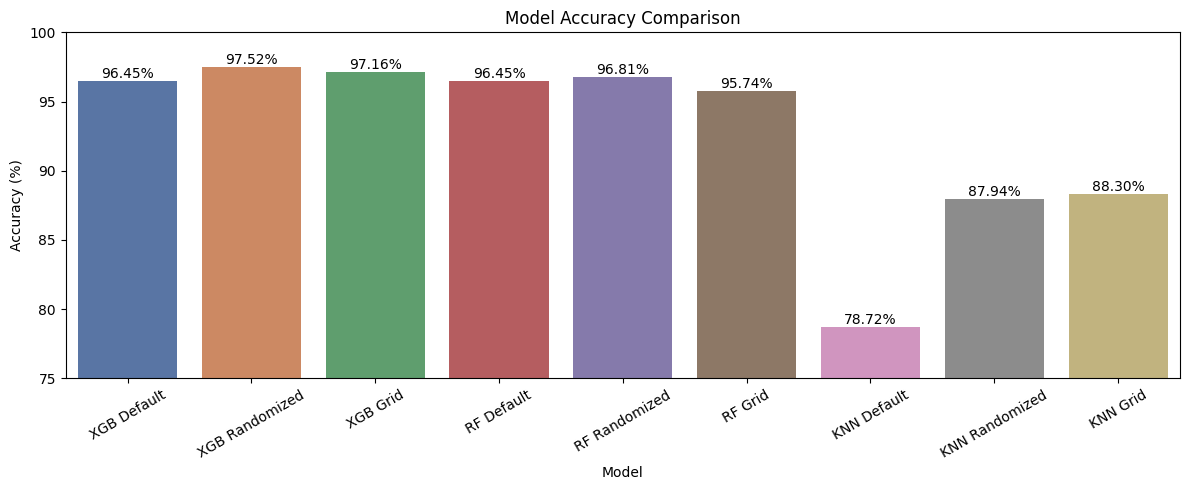

C:\Users\HELLO\AppData\Local\Temp\ipykernel_24828\4256000353.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric_name, data=df, palette='deep')


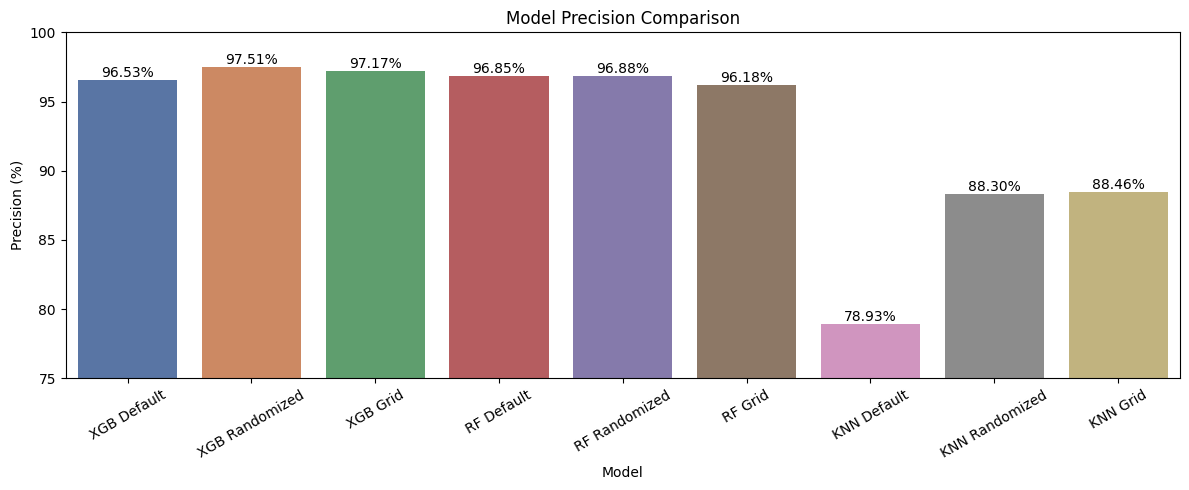

C:\Users\HELLO\AppData\Local\Temp\ipykernel_24828\4256000353.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric_name, data=df, palette='deep')


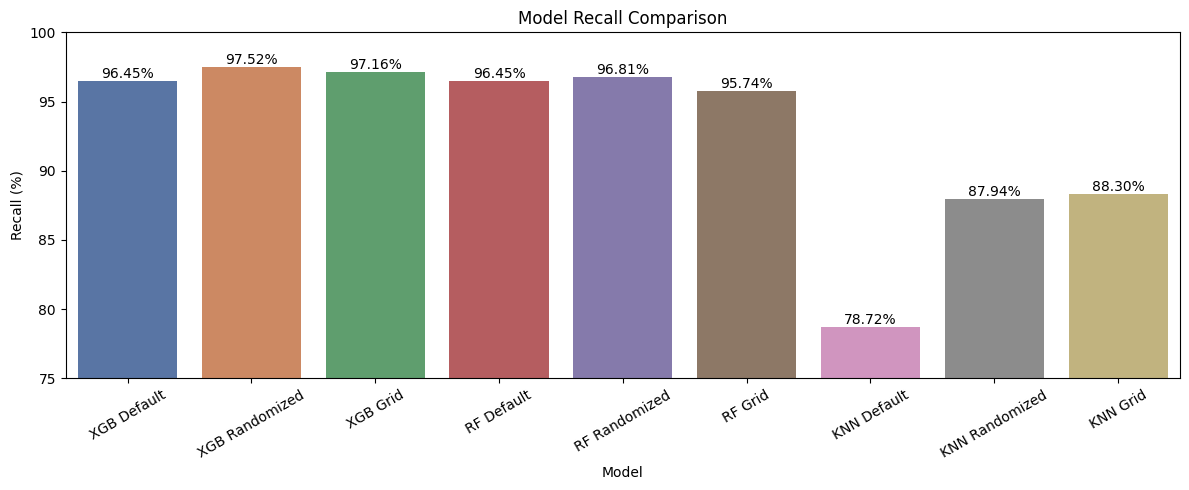

C:\Users\HELLO\AppData\Local\Temp\ipykernel_24828\4256000353.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y=metric_name, data=df, palette='deep')


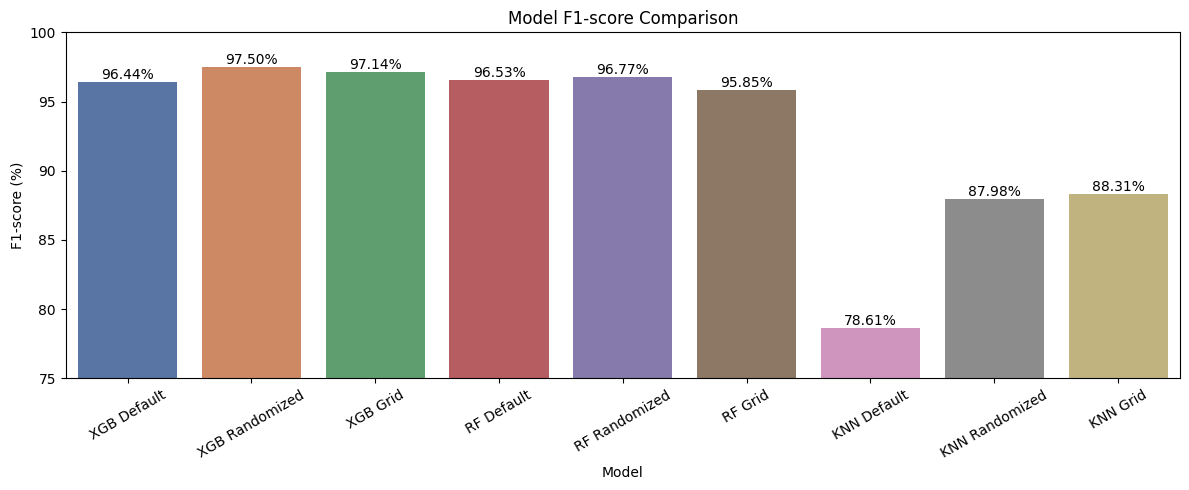

In [44]:
def get_metrics_from_report(report):
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
    return {
        'precision': report_dict['weighted avg']['precision'] * 100,
        'recall': report_dict['weighted avg']['recall'] * 100,
        'f1-score': report_dict['weighted avg']['f1-score'] * 100
    }

df_metrics = pd.DataFrame({
    'Model': [
        'XGB Default', 'XGB Randomized', 'XGB Grid',
        'RF Default', 'RF Randomized', 'RF Grid',
        'KNN Default', 'KNN Randomized', 'KNN Grid'
    ],
    'accuracy': [
        accuracy_score(y_test, y_pred) * 100,
        accuracy_score(y_test, y_pred_random) * 100,
        accuracy_score(y_test, y_pred_grid) * 100,
        accuracy_score(y_test, y_pred_rf) * 100,
        accuracy_score(y_test, y_pred_rf_random) * 100,
        accuracy_score(y_test, y_pred_rf_grid) * 100,
        accuracy_score(y_test, y_pred_knn) * 100,
        accuracy_score(y_test, y_pred_knn_random) * 100,
        accuracy_score(y_test, y_pred_knn_grid) * 100
    ],
    'precision': [
        precision_score(y_test, y_pred, average='weighted') * 100,
        precision_score(y_test, y_pred_random, average='weighted') * 100,
        precision_score(y_test, y_pred_grid, average='weighted') * 100,
        precision_score(y_test, y_pred_rf, average='weighted') * 100,
        precision_score(y_test, y_pred_rf_random, average='weighted') * 100,
        precision_score(y_test, y_pred_rf_grid, average='weighted') * 100,
        precision_score(y_test, y_pred_knn, average='weighted') * 100,
        precision_score(y_test, y_pred_knn_random, average='weighted') * 100,
        precision_score(y_test, y_pred_knn_grid, average='weighted') * 100
    ],
    'recall': [
        recall_score(y_test, y_pred, average='weighted') * 100,
        recall_score(y_test, y_pred_random, average='weighted') * 100,
        recall_score(y_test, y_pred_grid, average='weighted') * 100,
        recall_score(y_test, y_pred_rf, average='weighted') * 100,
        recall_score(y_test, y_pred_rf_random, average='weighted') * 100,
        recall_score(y_test, y_pred_rf_grid, average='weighted') * 100,
        recall_score(y_test, y_pred_knn, average='weighted') * 100,
        recall_score(y_test, y_pred_knn_random, average='weighted') * 100,
        recall_score(y_test, y_pred_knn_grid, average='weighted') * 100
    ],
    'f1-score': [
        f1_score(y_test, y_pred, average='weighted') * 100,
        f1_score(y_test, y_pred_random, average='weighted') * 100,
        f1_score(y_test, y_pred_grid, average='weighted') * 100,
        f1_score(y_test, y_pred_rf, average='weighted') * 100,
        f1_score(y_test, y_pred_rf_random, average='weighted') * 100,
        f1_score(y_test, y_pred_rf_grid, average='weighted') * 100,
        f1_score(y_test, y_pred_knn, average='weighted') * 100,
        f1_score(y_test, y_pred_knn_random, average='weighted') * 100,
        f1_score(y_test, y_pred_knn_grid, average='weighted') * 100
    ]
})

def plot_metric(df, metric_name):
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x='Model', y=metric_name, data=df, palette='deep')
    plt.title(f'Model {metric_name.capitalize()} Comparison')
    plt.ylim(75, 100)
    plt.ylabel(f'{metric_name.capitalize()} (%)')
    plt.xticks(rotation=30)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

for metric in ['accuracy', 'precision', 'recall', 'f1-score']:
    plot_metric(df_metrics, metric)